In [277]:
import numpy as np
import cv2
import scipy.optimize as opt
import math
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
#np.set_printoptions(precision=None, suppress=True)
np.set_printoptions(suppress=True)


In [309]:
#number of matching points
N = 8
n_images = 4
F = np.zeros((n_images,n_images,3,3))
# true_K = np.array([
#     [5,0,2],
#     [0,5,2],
#     [0,0,1]
#     ])
true_K = np.array([
    [800,0,256],
    [0,800,256],
    [0,0,1]
    ])
I = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0]
    ])

In [302]:
def calc_fund_matrix(points1,points2):
    '''
    Takes in 2 arrays of matching points 
    Return Fundamental matrix computes 
    using 8 point algorithm
    '''
#     F, mask = cv2.findFundamentalMat(points1,points2,cv2.FM_8POINT)
    F, mask = cv2.findFundamentalMat(points1,points2)

    return F 

In [282]:
def normalize_coordinates(p):
    # Normalization matrix
    T_m = normalization_matrix(p)
    # Normalized points
    p_norm = (T_m@(p.T)).T
    return p_norm, T_m

    
def manual_find_F_matrix(xy1,xy2):
    # Input: xy1 , xy2 - 2d array of points: row per point [x,y]
    # xy1 - for image 1, xy2 - for image 2
    # FM compute fundametal matrix from point correspondence
    #    at least 8 points are needed
    
    n_points = xy1.shape[0]
    if n_points < 8:
        print('8 points at least are needed')
    
    #add 3rd coordinate '1'
    xy1 = projectivation(xy1)
    xy2 = projectivation(xy2)
    
    
    #normalize coordinates
    xy1_norm, T1 = normalize_coordinates(xy1)
    xy2_norm, T2 = normalize_coordinates(xy2)
    
    # Preparing the equation matrix
    M = np.zeros((n_points,9))
    M[:,0] = xy1_norm[:,0]*xy2_norm[:,0] # x1 * x2
    M[:,1] = xy1_norm[:,0]*xy2_norm[:,1] # x1 * y2 
    M[:,2] = xy1_norm[:,0] # x1
    M[:,3] = xy1_norm[:,1]*xy2_norm[:,0] # y1 * x2
    M[:,4] = xy1_norm[:,1]*xy2_norm[:,1] # y1 * y2
    M[:,5] = xy1_norm[:,1] # y1
    M[:,6] = xy2_norm[:,0] # x2
    M[:,7] = xy2_norm[:,1] # y2
    M[:,8] = 1

    # calc M^T * M to get symmetruc square matrix
    W = M.T@M
    
    # desompose W into U (singular values), D (diagonal matrix), Vt (singular vectors)
    U,D,Vt = np.linalg.svd(W,compute_uv=True)
    a = U[:,-1]     # solution vector corresponding to the 
                    # least singular value
    A = np.reshape(a.T,(3,3))

    # Returning to non-normalized points
    F = np.linalg.inv(T2)@A@T1

    return F

In [283]:
### function used in class
def projectivation(p):
    '''
    Input: p, Nxd matrix = N points in R^d
    Output: q, Nx(d+1) = N points in P^d
    '''
    N,d = p.shape
    q = np.ones((N,d+1))
    q[:,0:d] = p 
    return q 

def affinization(q):
    '''
    Input: q, Nx(d+1) = N points in P^d
    Output: p, Nxd matrix = N points in R^d
    '''
    N,d1 = q.shape
    d = d1-1
    p = np.ones((N,d))
    p = q[:,0:d]/q[:,d:d+1] 
    
    return p

def normalization_matrix(p):
    '''
    Input: p: Nx2 matrix
    Output: T, normalization matrix (in projective plane) 
    '''

    # Computation
    m = np.mean(p,axis=0)
    q = p - np.repeat(m[np.newaxis,:],N,axis=0)
    w = np.sqrt(np.sum(q**2,axis=1))
    scale = 1/np.mean(w)

    # Normalization matrix
    T = np.zeros((3,3))
    T[2,2] = 1
    T[0,0] = scale
    T[0,2] = -m[0]*scale
    T[1,1] = scale
    T[1,2] = -m[1]*scale
        
    return T

In [284]:
def mendonca_cost_func(X):
    '''
    computes Mendonca & Cipolla Cost function to find the Optimal Intrinsic Parameters
    Input
    X      - Approximate Values of Intrinsics - 1D array with length 5
    Output
    E    - Computed Cost
    '''

    #Transform Intrinsics to Matrix Form
    K = np.array([
        [X[0],X[1],X[2]],
        [0,X[3],X[4]],
        [0,0,1]
    ])
    #Initialize Cost
    E = 0
    '''
       F - globally defined Fundamental Matrix between given two Images (F[i,j,3x3])
    '''
    # For the Denominator term of Mendonca & Cipolla's Equation
    nof_images = len(F[0]) #number of images given

    Den = nof_images*(nof_images-1)/2 # For N Images there are N(N-1)/2 Fundamental Matrices
  # 0 1 2 3 [0-1, 0-2,0-3, 1-2,1-3,2-3]
    # i  j
    # 0 -1 
    # 0 -2
    # 0 -3
    # 1- 2
    # 1 -3
    # 2 -3
  # len =4

    #Compute the Cost using Mendonca & Cipolla's Equation
    for i in range(0,nof_images-1):
        for j in range (i+1,nof_images):

            # Compute the Essential Matrix 'EM' from Fundamental of images i,j
            EM = K.T @ F[i,j,:,:] @ K

            # Compute SVD of Essential Matrix
            _,D,_ = np.linalg.svd(EM)
             # Singular Values (3rd value, D[3] is 0 according to theorem)
            r = D[0]
            s = D[1]
            
            #  Compute Cost

            E+= (1/Den) * (r - s)/s

    return E


In [285]:
def randomize_rt():
    angle = np.random.uniform(0,45)
    cos =  math.cos(angle)
    sin =  math.sin(angle)
    t = np.random.randint(-5,5,(3,1))
    t[2] = 0
    t = np.zeros((3,1))
    R = np.array([[cos,-sin,0],[sin,cos,0],[0,0,1]])
    Rt = np.concatenate((R,t),axis=1)
#     print (np.matrix(Rt))
    return Rt

In [286]:
def randomize_3d_points(num_of_points):
    world_points = np.random.randint(0,500,(num_of_points,3))
    return world_points

def get_projection_of_points(world_points):
    world_points_hom = projectivation(world_points)
    return world_points_hom

In [287]:
world_points = randomize_3d_points(N)
T1 = normalization_matrix(world_points)
world_points_hom = get_projection_of_points(world_points)

In [288]:
world_points_hom.shape

(8, 4)

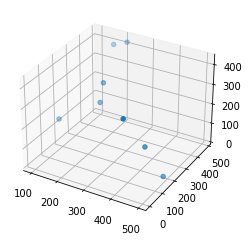

In [289]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(world_points[:,0],world_points[:,1],world_points[:,2])
plt.show()

In [290]:
(world_points_hom[0])

array([215., 483., 422.,   1.])

In [291]:
image0_p0 = np.zeros(3)
rt = randomize_rt()
image0_p0 = true_K @ I @ world_points_hom[0]

In [292]:
image0 = np.zeros((N,3))
for i in range(N):
    image0[i,:] = true_K @ I @ world_points_hom[i]
    image0[i,:] = image0[i,:]/image0[i,-1]

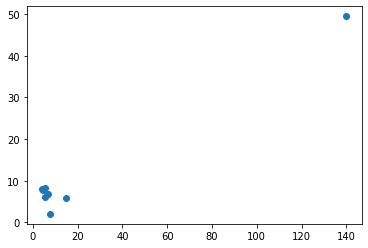

In [293]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(image0[:,0],image0[:,1])
plt.show()

In [310]:
projected = np.zeros((n_images,N,3))

for image in range(n_images):
    if (image == 0): # use the first image as it was not rotated
        rt = I
    else:
        rt = randomize_rt()
    print (np.matrix(rt))
    for point in range(N):
        projected[image,point,:] = true_K @ rt @ world_points_hom[point]
        projected[image,point,:]/= world_points[point,-1]


[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
[[ 0.803 -0.595  0.     0.   ]
 [ 0.595  0.803  0.     0.   ]
 [ 0.     0.     1.     0.   ]]
[[-1.     0.002  0.     0.   ]
 [-0.002 -1.     0.     0.   ]
 [ 0.     0.     1.     0.   ]]
[[-0.064  0.998  0.     0.   ]
 [-0.998 -0.064  0.     0.   ]
 [ 0.     0.     1.     0.   ]]


In [311]:
print(projected)

[[[   663.583   1171.64       1.   ]
  [   802.207   1249.103      1.   ]
  [   807.22     919.415      1.   ]
  [   997.7     1033.328      1.   ]
  [ 22344.889   7856.         1.   ]
  [   591.678   1210.774      1.   ]
  [  2335.07     865.302      1.   ]
  [  1166.638    264.511      1.   ]]

 [[    38.238   1234.315      1.   ]
  [   103.483   1379.092      1.   ]
  [   303.822   1117.206      1.   ]
  [   389.024   1322.144      1.   ]
  [ 13476.765  19514.515      1.   ]
  [   -42.832   1222.94       1.   ]
  [  1563.512   1983.481      1.   ]
  [   982.536    805.072      1.   ]]

 [[  -149.327   -660.641      1.   ]
  [  -287.76    -738.445      1.   ]
  [  -293.585   -408.77       1.   ]
  [  -483.784   -523.152      1.   ]
  [-21814.111  -7398.36       1.   ]
  [   -77.327   -699.597      1.   ]
  [ -1821.563   -358.419      1.   ]
  [  -654.615    245.247      1.   ]]

 [[  1143.478   -209.729      1.   ]
  [  1211.849   -353.055      1.   ]
  [   882.522   -336.817      1.

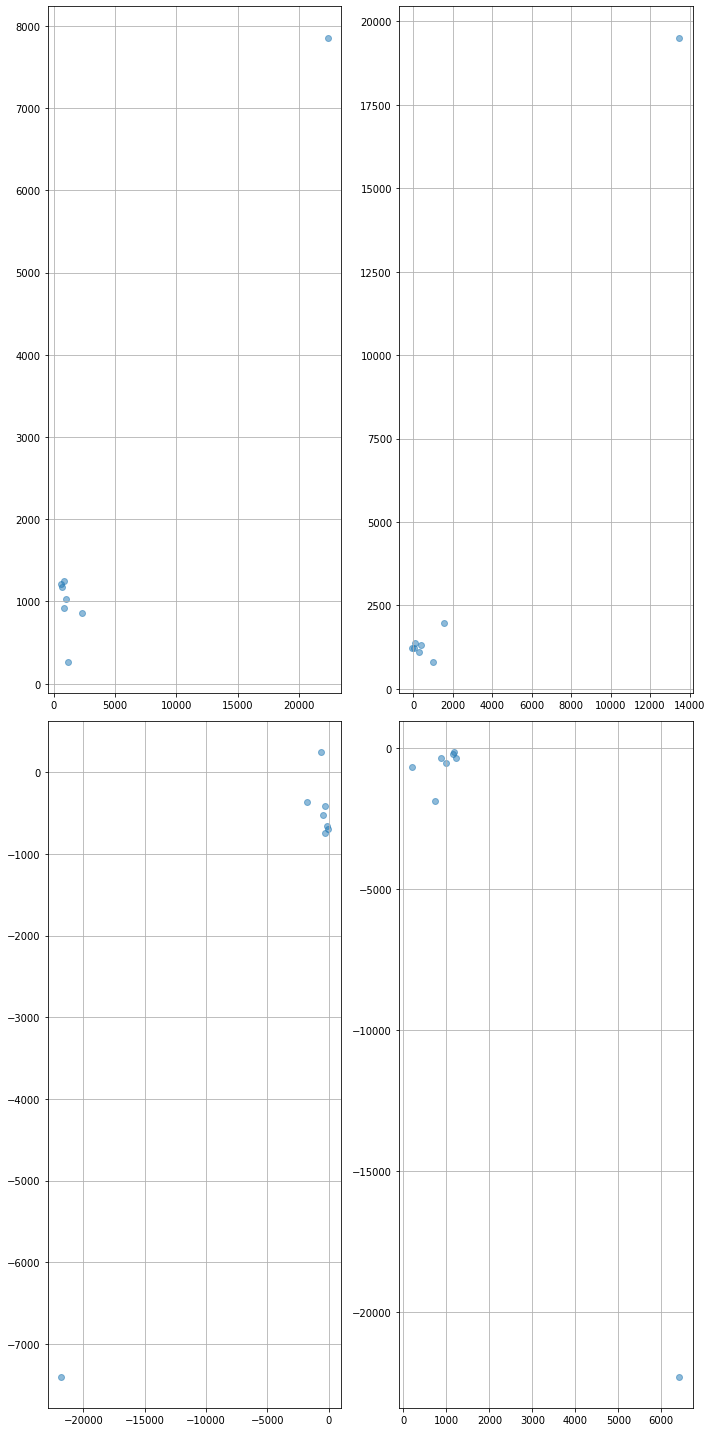

In [312]:
fig, axes = plt.subplots(2, 2, figsize=(10,20))

for i, ax in enumerate(axes.ravel()):
    ax.scatter(projected[i,:,0],projected[i,:,1], alpha=.5)
    ax.grid()
    
plt.tight_layout()

In [313]:
for i in range(n_images-1):
    for j in range(i+1,n_images):
        F[i,j] = calc_fund_matrix(projected[i,:,0:2],projected[j,:,0:2])

In [314]:
np.matrix(F[0,1])

matrix([[ 0.   ,  0.   , -0.005],
        [-0.   ,  0.   ,  0.   ],
        [ 0.002, -0.004,  1.   ]])

In [315]:
for i in range(n_images-1):
    for j in range(i+1,n_images):
        print(i,j)
        print(np.matrix(F[i,j]))

0 1
[[ 0.     0.    -0.005]
 [-0.     0.     0.   ]
 [ 0.002 -0.004  1.   ]]
0 2
[[-0.    -0.    -0.002]
 [ 0.    -0.    -0.   ]
 [-0.002 -0.     1.   ]]
0 3
[[-0.    -0.     0.001]
 [ 0.    -0.    -0.002]
 [-0.002  0.     1.   ]]
1 2
[[-0.     0.    -0.003]
 [-0.    -0.     0.002]
 [-0.001 -0.001  1.   ]]
1 3
[[ 0.     0.    -0.001]
 [-0.     0.    -0.001]
 [-0.001 -0.001  1.   ]]
2 3
[[-0.    -0.    -0.002]
 [ 0.    -0.    -0.005]
 [ 0.011 -0.002  1.   ]]


In [324]:
initial_K =  np.random.randint(-5,5,(5))
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')
# res = opt.minimize(mendonca_cost_func,x0=initial_K)

In [321]:
res

      fun: 2.849609724159079e-05
 hess_inv: array([[ 0.001, -0.001, -0.   ,  0.001,  0.   ],
       [-0.001,  0.001,  0.   , -0.001, -0.   ],
       [-0.   ,  0.   ,  0.   , -0.   , -0.   ],
       [ 0.001, -0.001, -0.   ,  0.001,  0.   ],
       [ 0.   , -0.   , -0.   ,  0.   ,  0.   ]])
      jac: array([-0.043, -0.008,  0.023,  0.043, -0.015])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1989
      nit: 190
     njev: 330
   status: 2
  success: False
        x: array([ -3.105,  -0.   , 256.   ,  -3.105, 256.   ])

In [322]:
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],res.x[1],res.x[2]],[0,res.x[3],res.x[4]],[0,0,1]])
print (np.matrix(result_K))

[[ -3.105  -0.    256.   ]
 [  0.     -3.105 256.   ]
 [  0.      0.      1.   ]]


In [323]:
print(np.matrix(true_K))

[[800   0 256]
 [  0 800 256]
 [  0   0   1]]


In [ ]:
image0_p0/image0_p0[2]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(world_points[:,0],world_points[:,1],world_points[:,2])
plt.show()

In [ ]:
# EXPERIMENT

# array of n_images with original coordinates of N points (x,y)
p = np.zeros((n_images,N,2))
# array of n_images with projective coordinats of M points (x,y,1)
pj = np.zeros((n_images,N,3))

# randomly initialize 1st image (index #0)
p[0] = np.random.randint(0,500,(N,2))
pj[0] = projectivation(p[0])

#init random matrices to transform original image
A = np.random.randint(-6,6,(n_images-1,3,3))
A[:,] = np.triu(A[:,])
# transform original image to get new images 
for i in range(1,n_images):
    pj[i] = (A[i-1]@pj[0].T).T
    p[i] = affinization(pj[i])
   
# insert noise
noise_level1 = 0.25
for i in range(n_images):
    p[i] += noise_level1*np.random.randn(N,2)

In [ ]:
print (A[0])

In [ ]:
print (p.shape)

In [ ]:
for i in range(n_images-1):
    for j in range(i+1,n_images):
        F[i,j] = calc_fund_matrix(p[i],p[j])

In [ ]:
initial_K =  np.random.randint(-5,5,(5))

In [ ]:
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')

In [ ]:
print (res)

In [ ]:
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],res.x[1],res.x[2]],[0,res.x[3],res.x[4]],[0,0,1]])
print (np.matrix(result_K))

In [ ]:
#reconststruction

#find Fundamental matrix
F12 = np.zeros((3,3))
F12 = calc_fund_matrix(p[0],p[1])

#find Essential matrix
EM = result_K.T @ F @ result_K

#factorize EM to find R,t
U,D,Vt = np.linalg.svd(EM)

In [ ]:
randomize_rt()